# Dense Neuronal Network Model for PTB data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: Standard Scaler

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
**Input** : the original data.   
ptbdb_normal.csv  
ptbdb_abnormal.csv  

Output: DNN model trained  
model_dnn_ptb.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'ptb_train_standard_oversampling.csv', 
    'test': data_path + 'ptb_test_standard_oversamling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_dnn_ptb.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [5]:
X_train.shape[1]

187

# Dense Neuronal Network with Standard Scaler

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# set seeed
tf.random.set_seed(42)

# define model
model = Sequential() # Sequential model is used to add layers one by one to the model, in a linear manner

# Input Layer
model.add(Dense(187, activation='relu', input_shape=(X_train.shape[1],))) # 187 neurons in the input layer, because we have 187 features


# Hidden Layers with BatchNormalization and Dropout for regularization to prevent overfitting
model.add(Dense(64, activation= 'relu')) 
model.add(BatchNormalization()) # BatchNormalization is used to normalize the activations of the previous layer at each batch
model.add(Dropout(0.3)) # Dropout is used to prevent overfitting. 0.3 means 30% of the neurons will be turned off randomly

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


# Output Layer for binary classification of the target
model.add(Dense(1, activation='sigmoid')) # 1 means 1 neuron in the output layer, sigmoid, because we want to predict probabilities

# Choose an optimizer
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002)# Change this line to use a different optimizer

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# binary_crossentropy is used for binary classification problems
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs with no improvement after which training will be stopped
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001) # the factor by which the learning rate will be reduced, min_lr is the lower bound for the learning rate


# Callbacks for plotting
train_loss = [] # to store training loss
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size
batch_size = 32 

# Training
epochs = 100 # Number of epochs to train the model
for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_data=(X_test, y_test), 
                        verbose=0, callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to the respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress at each 10th epoch for feedback
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 187)            │        35,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,957 (195.14 KB)

 Trainable params: 49,749 (194.33 KB)

 Non-trainable params: 208 (832.00 B)

Epoch 10/100 - Loss: 0.1781, Val Loss: 0.1222, Accuracy: 0.9393, Val Accuracy: 0.9574
Epoch 20/100 - Loss: 0.1109, Val Loss: 0.0842, Accuracy: 0.9654, Val Accuracy: 0.9707
Epoch 30/100 - Loss: 0.0734, Val Loss: 0.0712, Accuracy: 0.9770, Val Accuracy: 0.9779
Epoch 40/100 - Loss: 0.0569, Val Loss: 0.0535, Accuracy: 0.9817, Val Accuracy: 0.9841
Epoch 50/100 - Loss: 0.0446, Val Loss: 0.0576, Accuracy: 0.9861, Val Accuracy: 0.9833
Epoch 60/100 - Loss: 0.0367, Val Loss: 0.0474, Accuracy: 0.9889, Val Accuracy: 0.9872
Epoch 70/100 - Loss: 0.0379, Val Loss: 0.0559, Accuracy: 0.9893, Val Accuracy: 0.9860
Epoch 80/100 - Loss: 0.0260, Val Loss: 0.0545, Accuracy: 0.9930, Val Accuracy: 0.9886
Epoch 90/100 - Loss: 0.0230, Val Loss: 0.0627, Accuracy: 0.9936, Val Accuracy: 0.9848
Epoch 100/100 - Loss: 0.0263, Val Loss: 0.0495, Accuracy: 0.9929, Val Accuracy: 0.9891


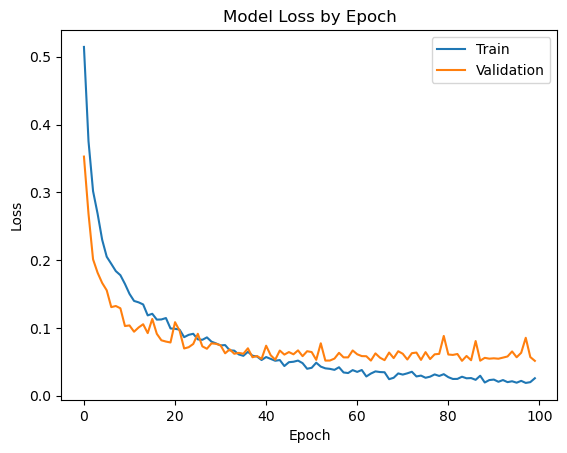

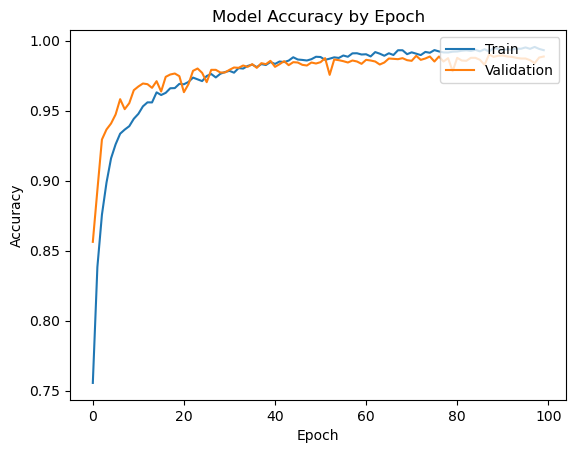

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
[[2075   12]
 [  36 2080]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2087
           1       0.99      0.98      0.99      2116

    accuracy                           0.99      4203
   macro avg       0.99      0.99      0.99      4203
weighted avg       0.99      0.99      0.99      4203

F1 Score: 0.9885931558935361


In [23]:
# Plotting the Loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class)}")

# Save DNN Model

In [27]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(model, model_file)